In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr
import anndata as ad
import seaborn as sns
import pickle

from TISSUE.tissue.main import *

### Some illustrative distribution plots

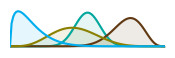

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

x = np.linspace(0,1, 100)

plt.figure(figsize=(2,0.5))
plt.xlim(0, 1)
plt.plot(x, beta.pdf(x, 20, 20), color='#00A79D')
plt.fill_between(x, beta.pdf(x, 20, 20), 0, color='#00A79D', alpha=0.1)
plt.plot(x, beta.pdf(x, 15, 5), color='#603913')
plt.fill_between(x, beta.pdf(x, 15, 5), 0, color='#603913', alpha=0.1)
plt.plot(x, beta.pdf(x, 5, 7), color='#8B8000')
plt.fill_between(x, beta.pdf(x, 5, 7), 0, color='#8B8000', alpha=0.1)
plt.plot(x, beta.pdf(x, 1.5, 10), color='#00AEEF')
plt.fill_between(x, beta.pdf(x, 1.5, 10), 0, color='#00AEEF', alpha=0.1)
plt.axis('off')
plt.savefig("plots/scpi_exploratory/example_distributions.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Imputation performance

In [2]:
datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17"]
methods = ['knn', 'spage', 'tangram']

dataset_col = []
method_col = []
R_col = []
Spearman_col = []
MAE_col = []

for d in datasets:
    adata = sc.read_h5ad("scg_results/scpi/2023Feb20_k4k1_SDbasedCCplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    for method in methods:
        
        imputed = np.array(adata.obsm[method+"_predicted_expression"])
        actual = adata[:,adata.obsm[method+"_predicted_expression"].columns].X
        
        for j in range(adata.obsm[method+"_predicted_expression"].shape[1]):
            not_nans = (~np.isnan(imputed[:,j]) & ~np.isnan(actual[:,j]))
            r, p = pearsonr(imputed[not_nans,j], actual[not_nans,j])
            rho, p = spearmanr(imputed[:,j], actual[:,j])
            mae = np.nanmean(np.abs(imputed[:,j]-actual[:,j]))
            
            dataset_col.append(d+f"\nn={n_cells}\np={n_genes}") # add n_cell/n_gene info
            method_col.append(method)
            R_col.append(r)
            Spearman_col.append(rho)
            MAE_col.append(mae)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


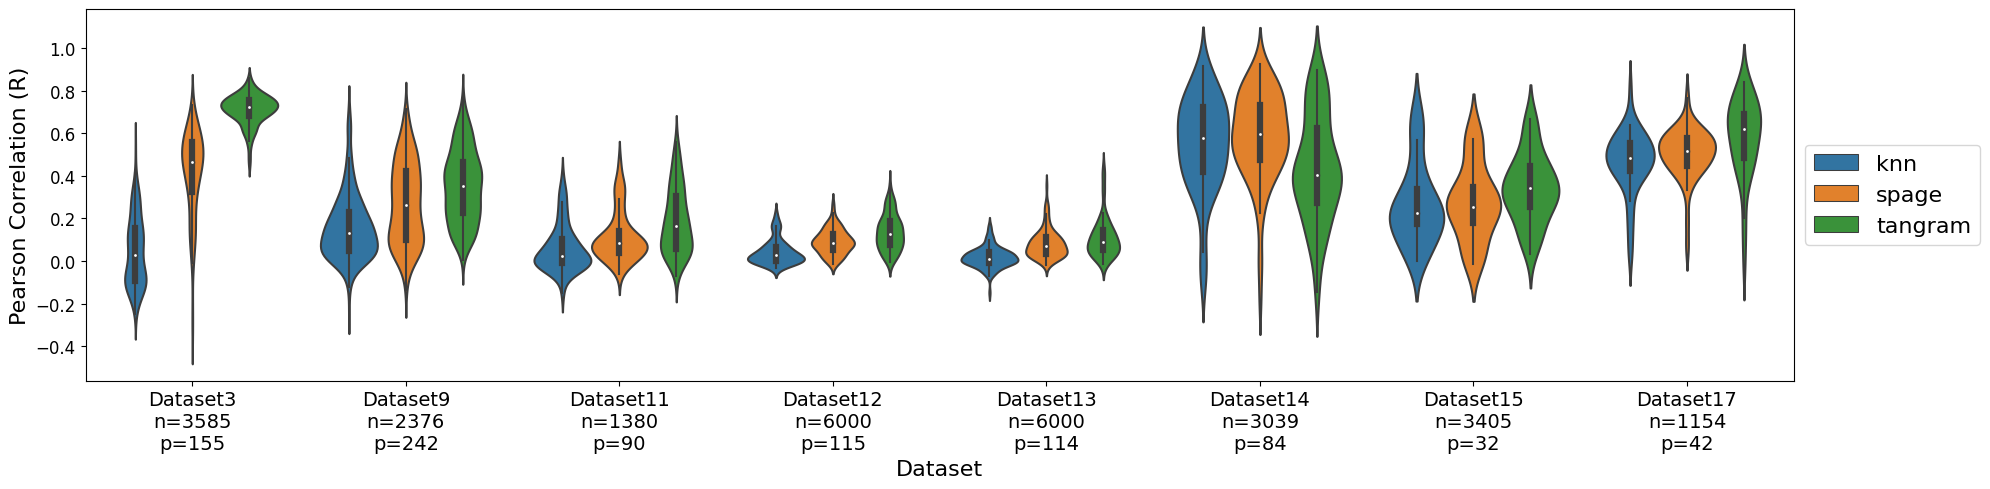

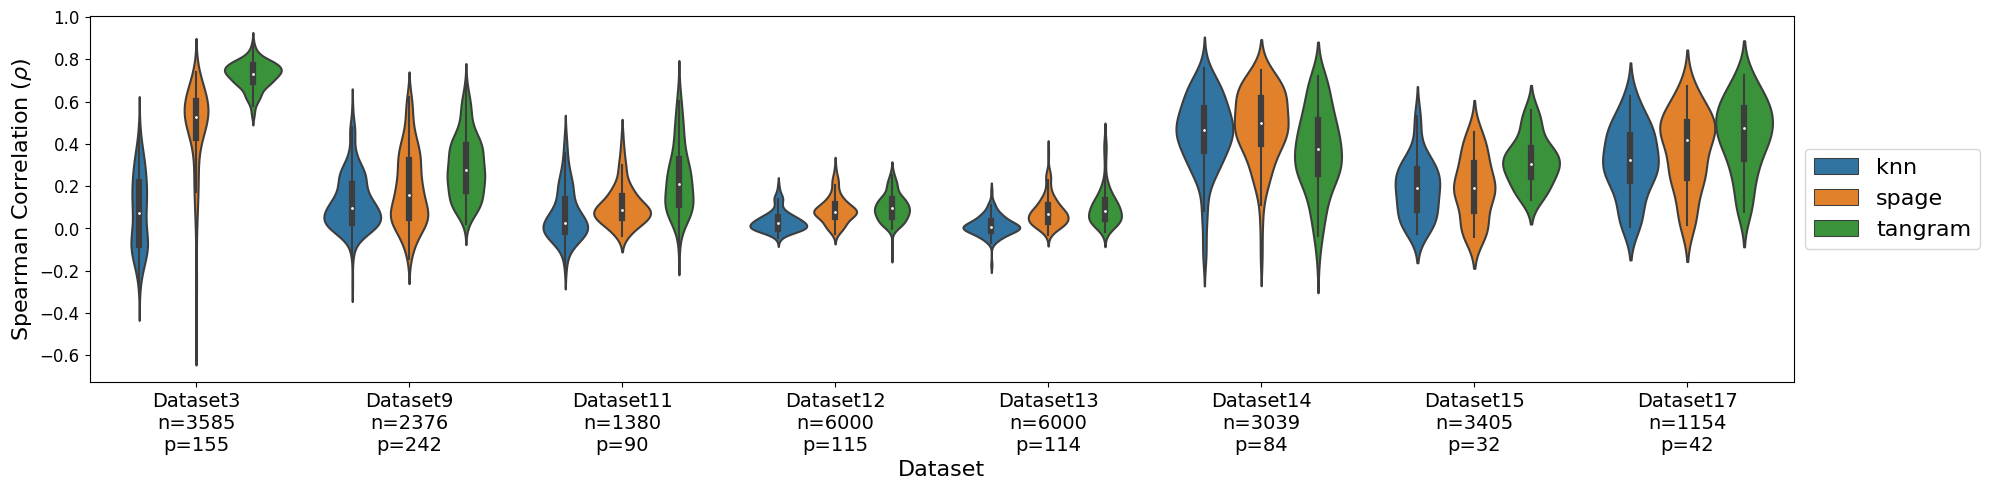

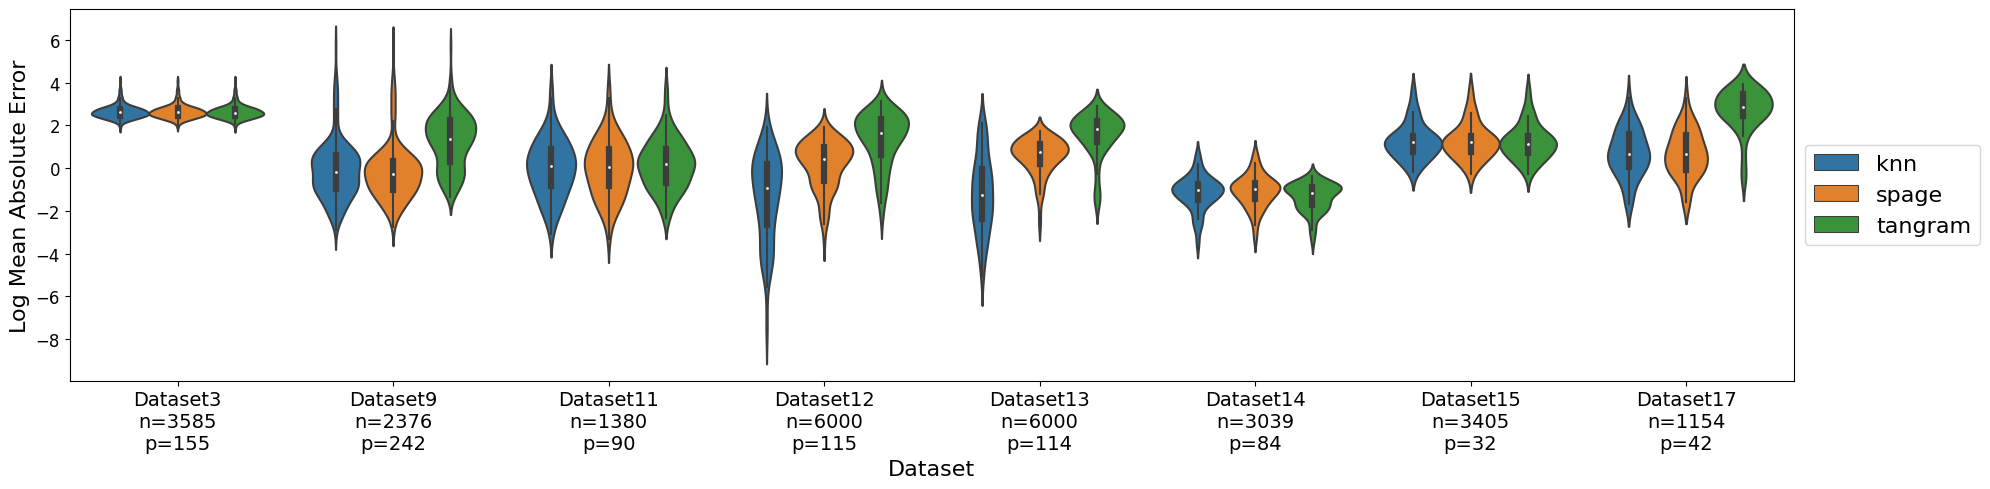

In [4]:
df = pd.DataFrame([])
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Pearson"] = R_col
df["Spearman"] = Spearman_col
df["MAE"] = MAE_col
df["MAE"] = df["MAE"].astype(float)
df["log MAE"] = np.log(df["MAE"])

# Pearson
plt.figure(figsize=(20,5))
sns.violinplot(x="Dataset", y="Pearson", hue="Method", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel("Pearson Correlation (R)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, ncol=1)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/violin_performance_pearson.pdf', dpi=300, bbox_inches='tight')
plt.show()


# Spearman
plt.figure(figsize=(20,5))
sns.violinplot(x="Dataset", y="Spearman", hue="Method", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel(r"Spearman Correlation ($\rho$)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, ncol=1)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/violin_performance_spearman.pdf', dpi=300, bbox_inches='tight')
plt.show()


# MAE
plt.figure(figsize=(20,5))
sns.violinplot(x="Dataset", y="log MAE", hue="Method", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel("Log Mean Absolute Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, ncol=1)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/violin_performance_logmae.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Score distributions

In [13]:
datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17"] 
methods = ['knn', 'spage', 'tangram']

dataset_col = []
method_col = []
group_col = []
score_col = []

for d in datasets:
    adata = sc.read_h5ad("scg_results/scpi/2023Feb20_k4k1_SDbasedCCplus1/"+d+"_knn_spage_tangram_NOCV.h5ad")
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    for method in methods:
        
        # get scores and groups matched
        scores = adata.obsm[method+"_predicted_expression_score"]
        groups = pd.DataFrame(adata.obsm[method+"_predicted_expression_groups"], columns=adata.obsm[method+"_predicted_expression"].columns)
        groups = np.array(groups[scores.columns]).flatten()
        scores = np.array(scores).flatten()
        
        # filter outliers to keep x-axis
        scores[(scores==np.inf)|(scores==-np.inf)] = np.nan
        groups = groups[~(np.isnan(scores))&(scores<np.nanquantile(scores,0.95))&(scores>0)] # filter out nans, outliers, (and zeros as in the CI setup)
        scores = scores[~(np.isnan(scores))&(scores<np.nanquantile(scores,0.95))&(scores>0)]
        
        # append results
        dataset_col.append([d]*len(groups))#([d+f"\nn={n_cells}\np={n_genes}"]*len(groups)) # add n_cell/n_gene info
        method_col.append([method]*len(groups))
        group_col.append(groups)
        score_col.append(scores)
        
dataset_col = np.concatenate(dataset_col)
method_col = np.concatenate(method_col)
group_col = np.concatenate(group_col)
score_col = np.concatenate(score_col)

In [14]:
df = pd.DataFrame([])
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Group"] = group_col
df["Log Score"] = np.log(score_col)
df["Score"] = score_col

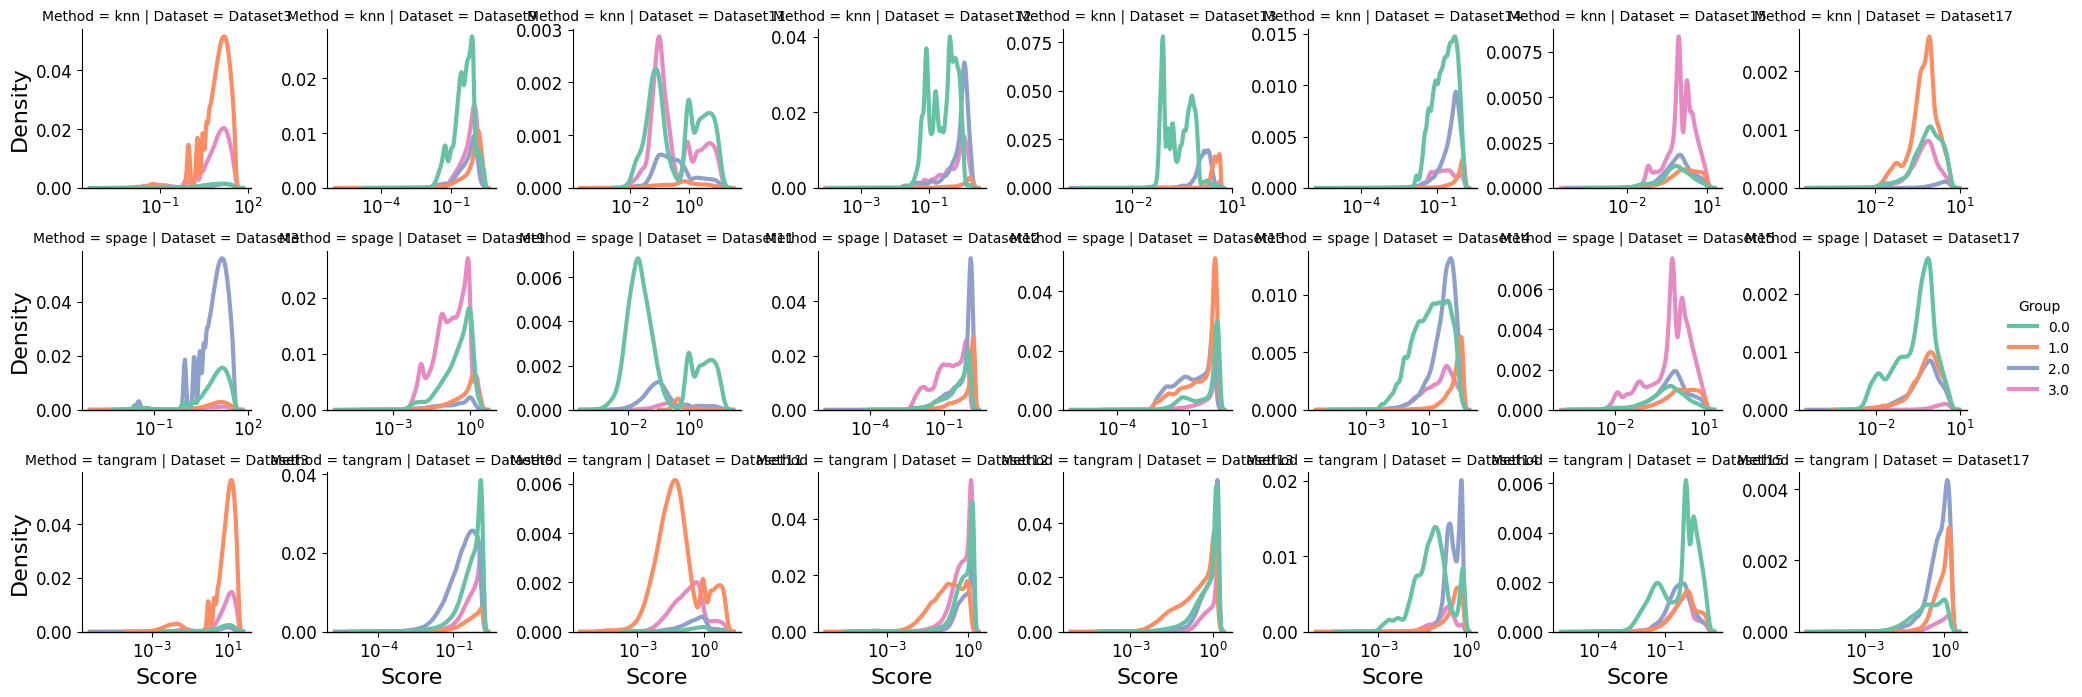

In [7]:
width = 20
height = 7
g = sns.displot(data=df, x="Score", hue="Group", col="Dataset", row="Method",
            kind="kde", log_scale=True, palette="Set2", linewidth=3,
            height=(height/3), aspect=(width/8/(height/3)),
            facet_kws=dict(sharey=False,sharex=False))
#g.fig.set_dpi(300)
for region,ax in g.axes_dict.items():
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig('plots/scpi_datasets/density_log_scores.pdf')
plt.show()

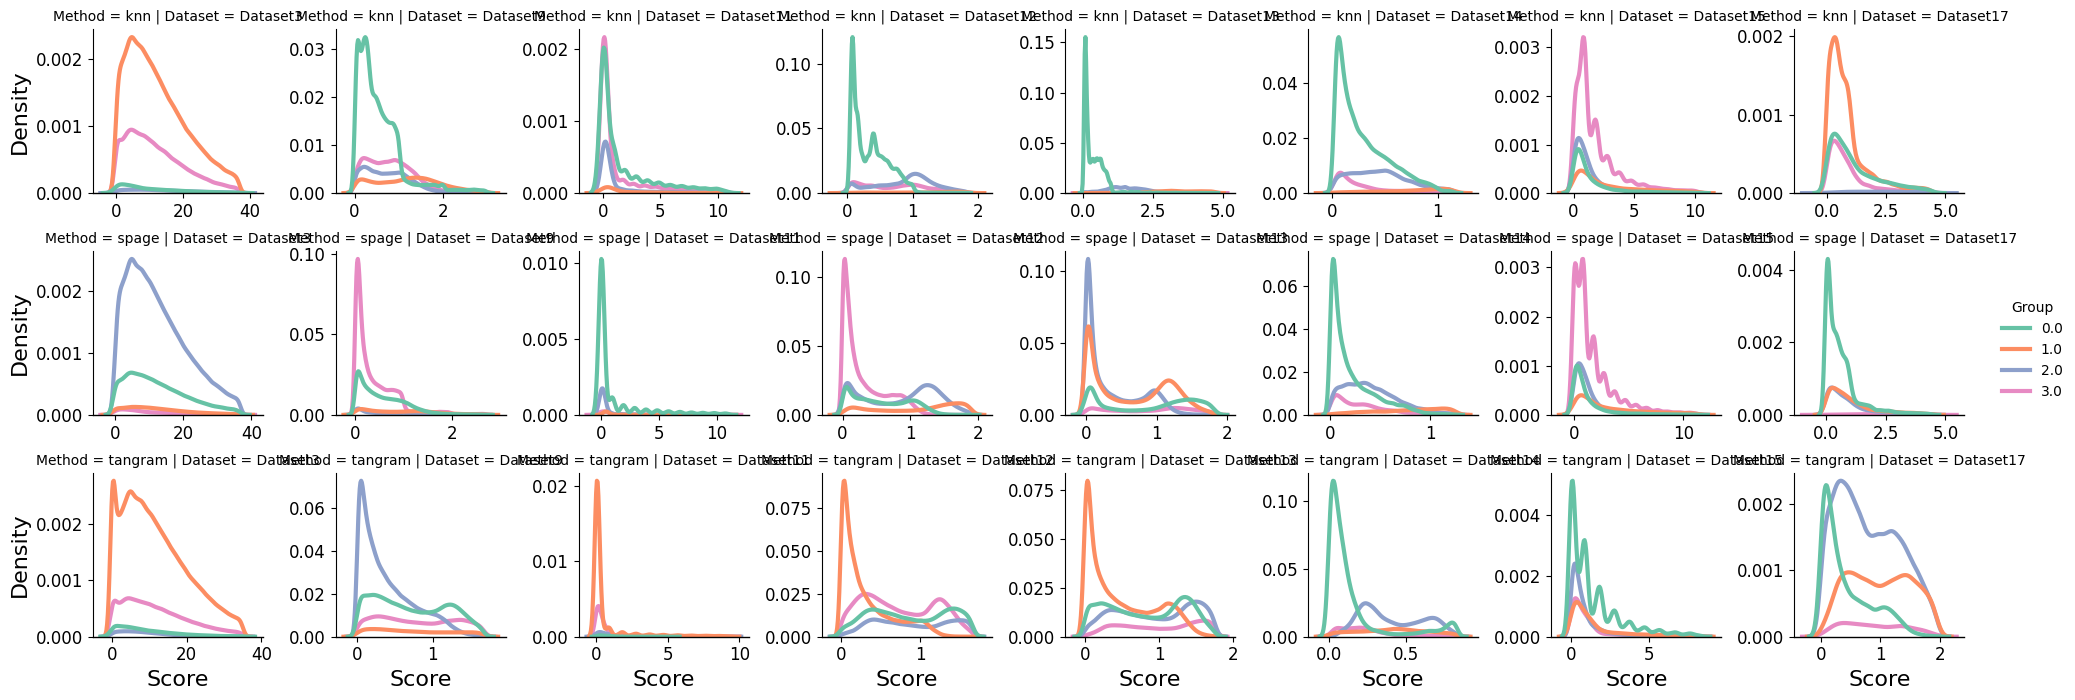

In [8]:
width = 20
height = 7
g = sns.displot(data=df, x="Score", hue="Group", col="Dataset", row="Method",
            kind="kde", log_scale=False, palette="Set2", linewidth=3,
            height=(height/3), aspect=(width/8/(height/3)),
            facet_kws=dict(sharey=False,sharex=False))
#g.fig.set_dpi(300)
for region,ax in g.axes_dict.items():
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig('plots/scpi_datasets/density_scores.pdf')
plt.show()

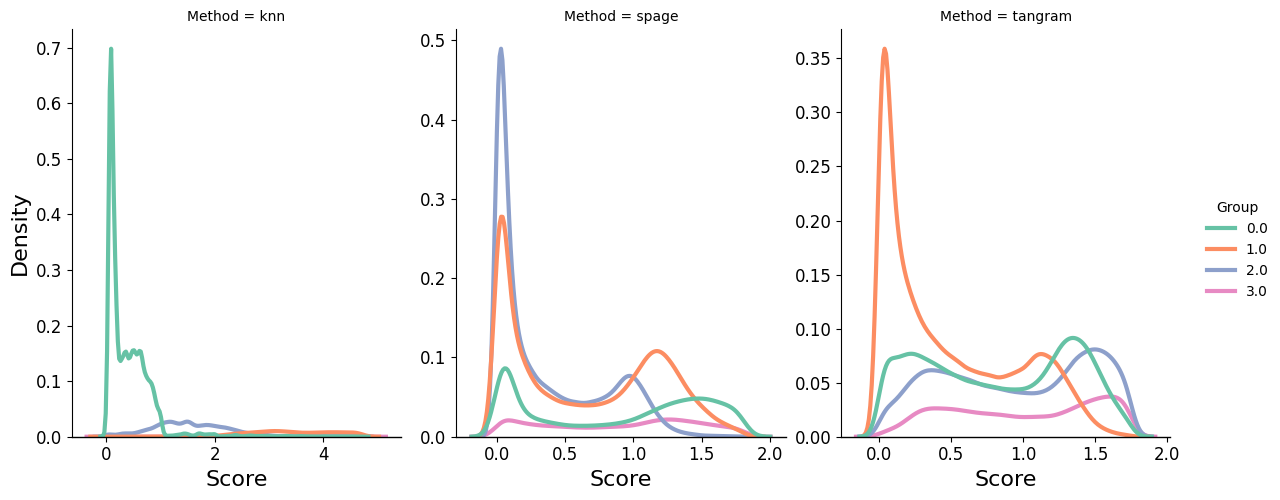

In [16]:
# Subsetted to Dataset13

subdf = df[df['Dataset']=="Dataset13"]

width = 12
height = 5
g = sns.displot(data=subdf, x="Score", hue="Group", col="Method",
            kind="kde", log_scale=False, palette="Set2", linewidth=3,
            height=height, aspect=(width/3/height),
            facet_kws=dict(sharey=False,sharex=False))
for region,ax in g.axes_dict.items():
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig('plots/scpi_datasets/density_scores_dataset13.pdf')
plt.show()

## Spatial uncertainty correlation with error

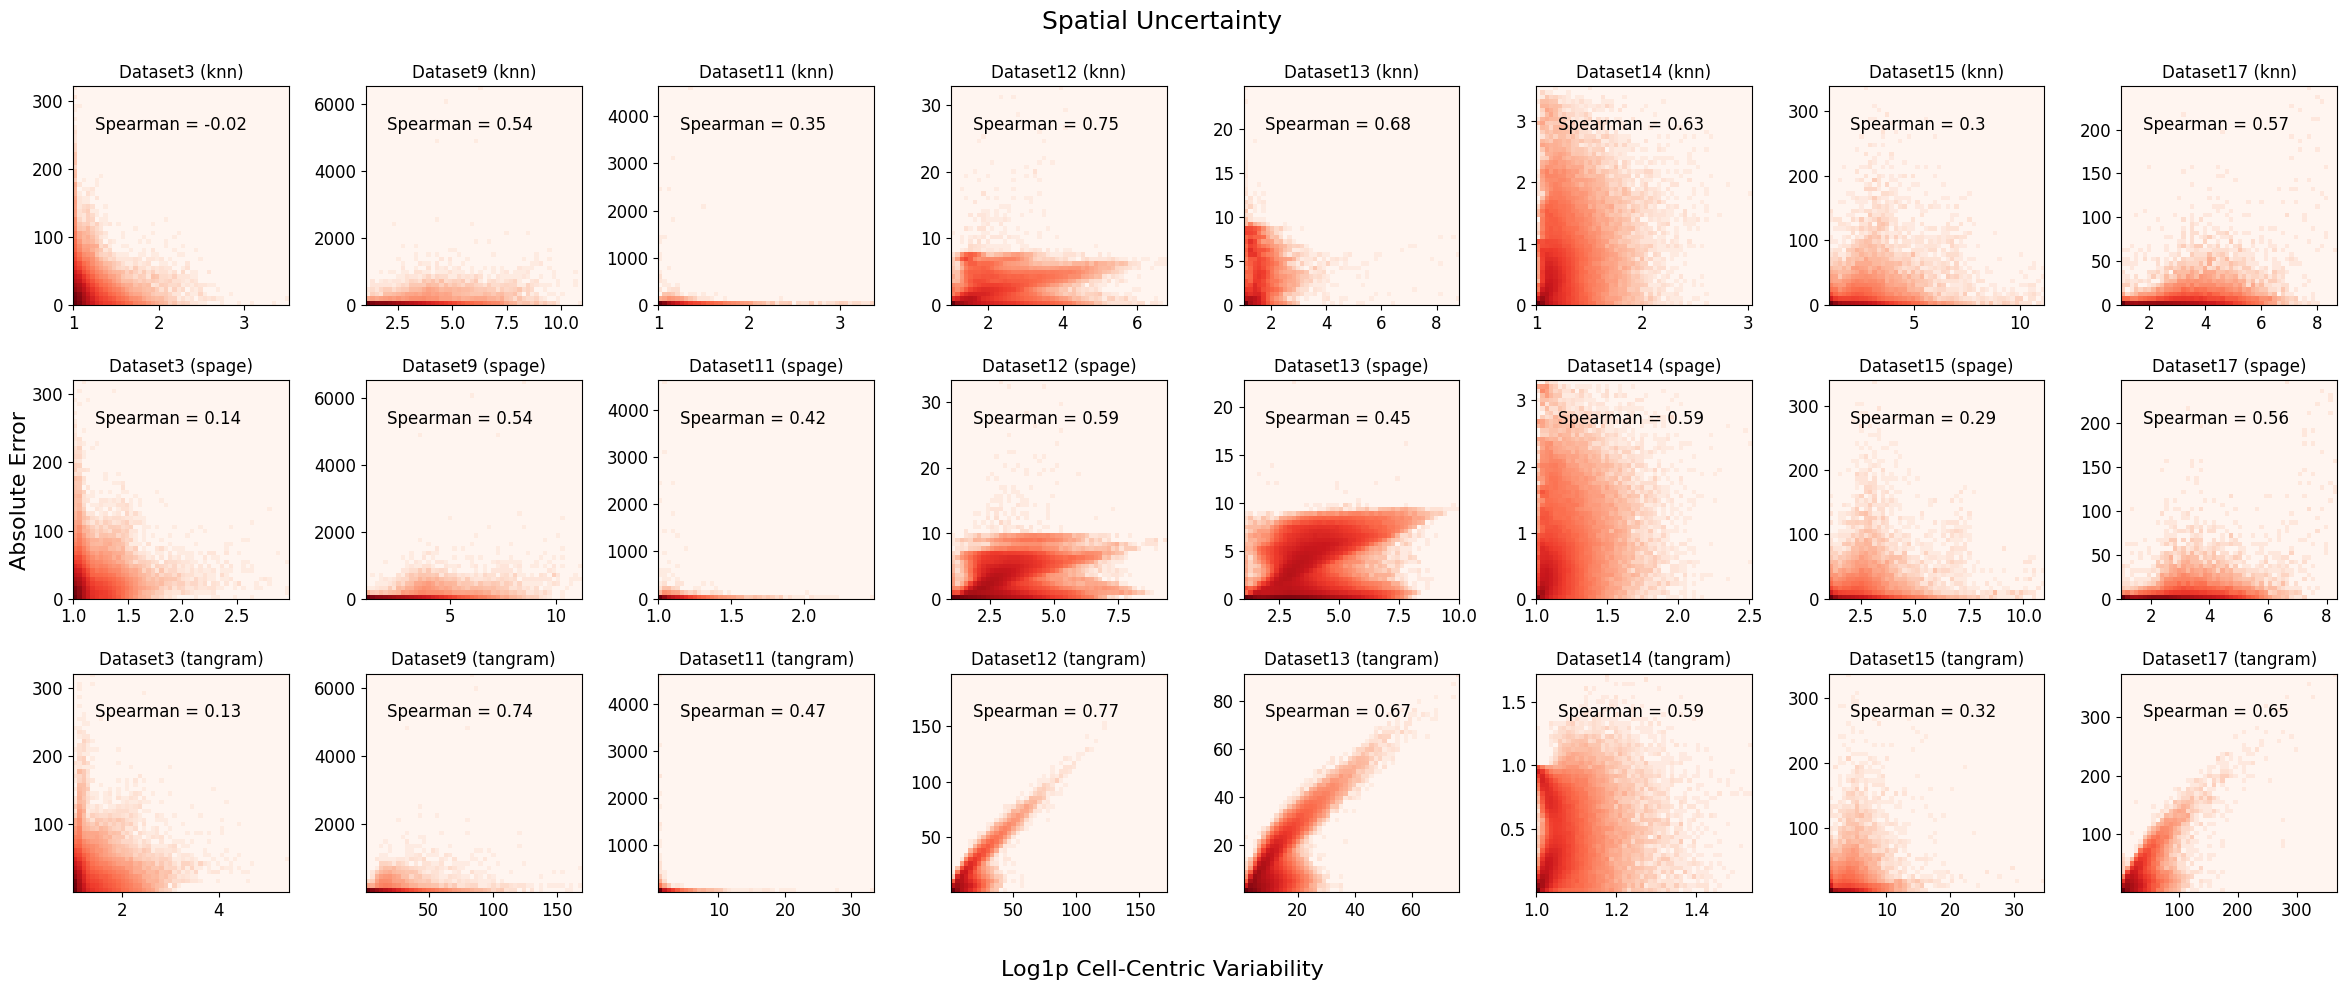

In [11]:
datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17"] 
methods = ['knn', 'spage', 'tangram']


fig, axs = plt.subplots(nrows=len(methods), ncols=len(datasets), sharex=False, sharey=False, figsize=(24, 10))

for i, d in enumerate(datasets):
    adata = sc.read_h5ad("scg_results/scpi/2023Feb20_k4k1_SDbasedCCplus1/"+d+"_knn_spage_tangram_NOCV.h5ad")
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    for j, method in enumerate(methods):
        
        # get uncertainties, errors matched
        genes = adata.var_names
        uncertainties = adata.obsm[method+"_predicted_expression_uncertainty"][genes]
        errs = np.abs(adata.obsm[method+"_predicted_expression"][genes]-adata.X)
        uncertainties = np.array(uncertainties).flatten()
        errs = np.array(errs).flatten()
        
        # filter outliers to keep x-axis
#         errs[(errs==np.inf)|(errs==-np.inf)] = np.nan
#         uncertainties = uncertainties[~(np.isnan(errs))&(errs<np.nanquantile(errs,0.95))&(errs>0)] # filter out nans, outliers, (and zeros as in the CI setup)
#         errs = errs[~(np.isnan(errs))&(errs<np.nanquantile(errs,0.95))&(errs>0)]
        
        # make histogram plot
        axs[j,i].set_title(f"{d} ({method})")
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        axs[j,i].tick_params(axis='both', which='minor', labelsize=12)
        
        rho, p = spearmanr(uncertainties, errs)
        heatmap, xedges, yedges = np.histogram2d(uncertainties, errs, bins=50)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        axs[j,i].imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
        axs[j,i].annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=12)
        #axs[j,i].colorbar()
        
fig.suptitle("Spatial Uncertainty", fontsize=18)
fig.supxlabel("Log1p Cell-Centric Variability", fontsize=16)
fig.supylabel("Absolute Error", fontsize=16)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_datasets/uncertainty_error_correlations.pdf')
plt.show()

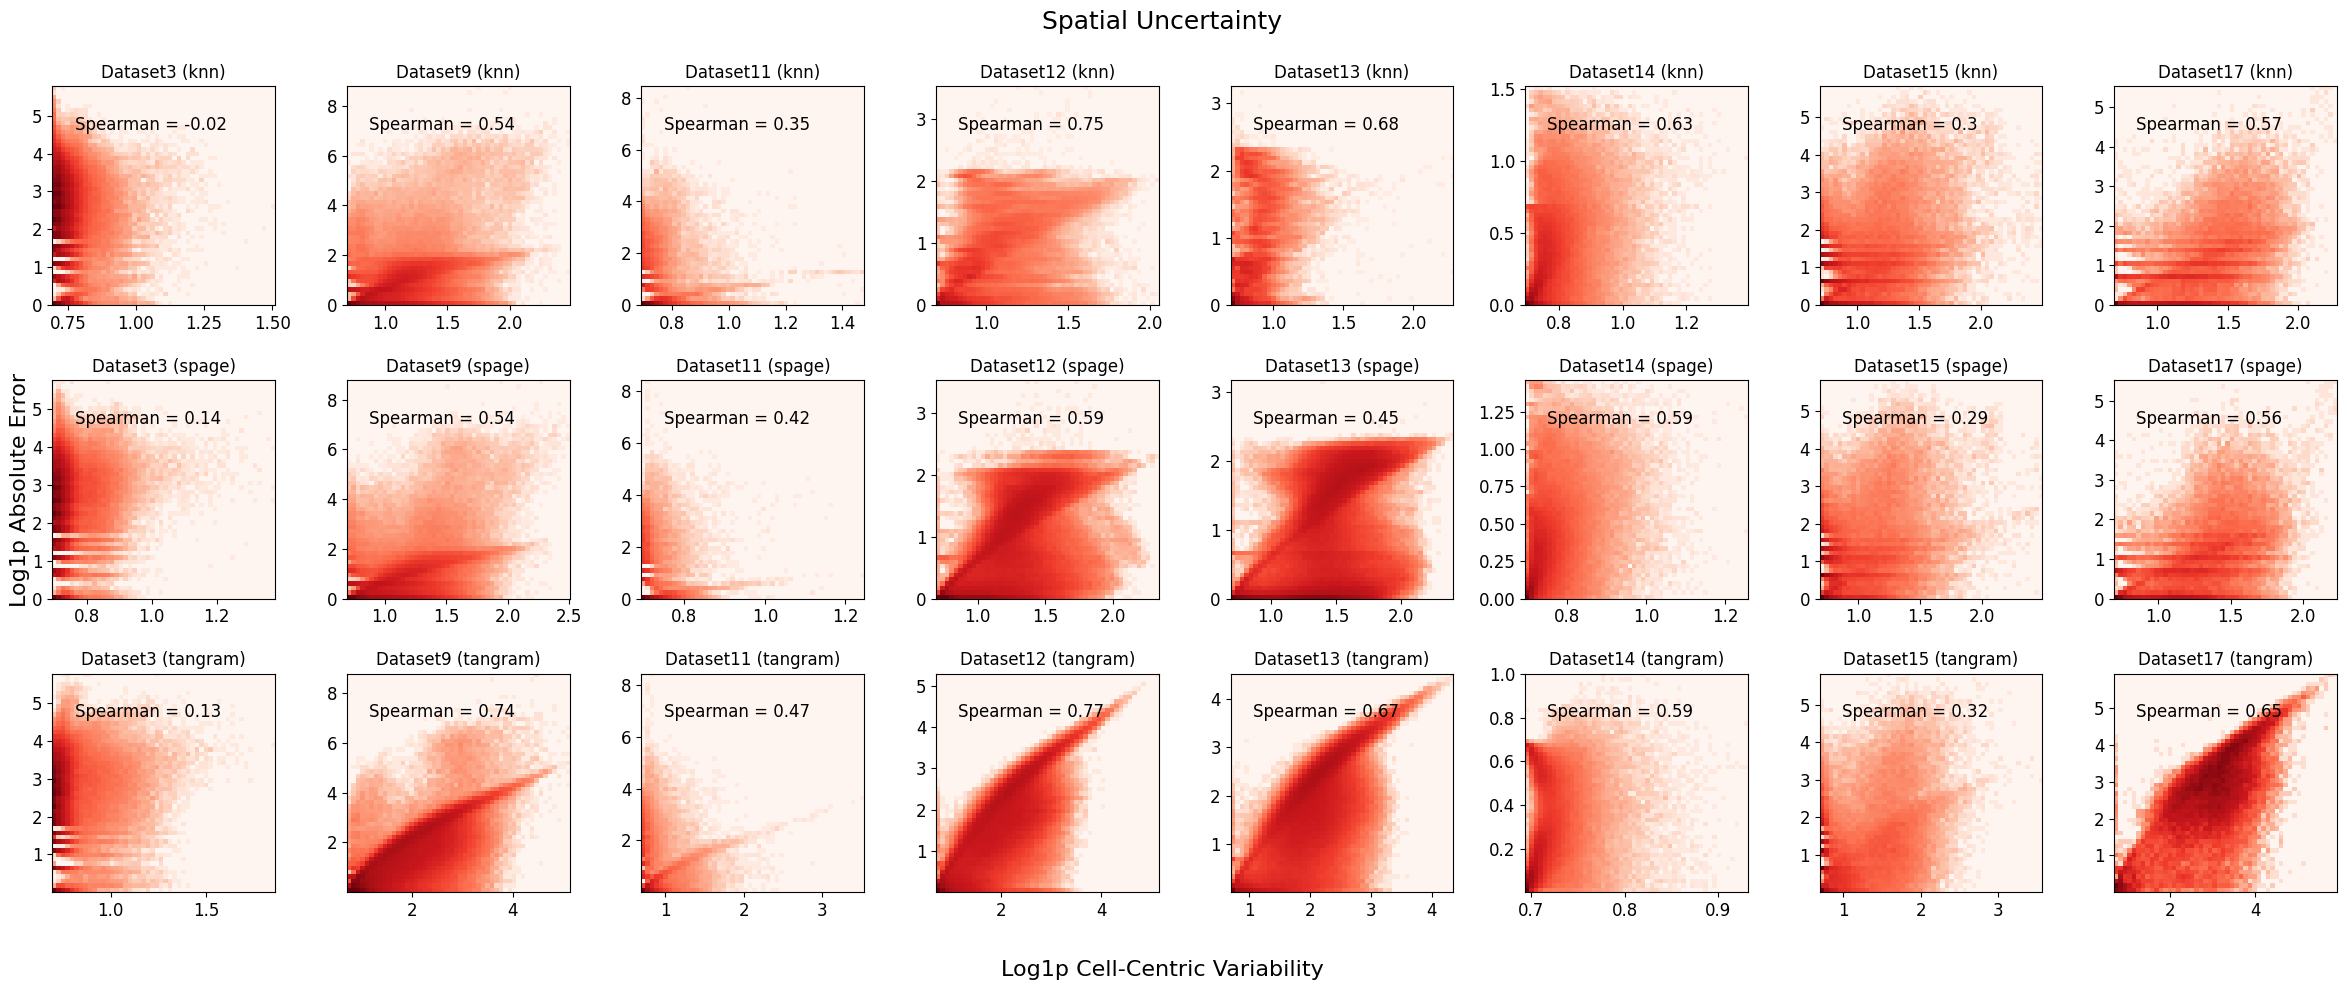

In [12]:
datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17"] 
methods = ['knn', 'spage', 'tangram']


fig, axs = plt.subplots(nrows=len(methods), ncols=len(datasets), sharex=False, sharey=False, figsize=(24, 10))

for i, d in enumerate(datasets):
    adata = sc.read_h5ad("scg_results/scpi/2023Feb20_k4k1_SDbasedCCplus1/"+d+"_knn_spage_tangram_NOCV.h5ad")
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    for j, method in enumerate(methods):
        
        # get uncertainties, errors matched
        genes = adata.var_names
        uncertainties = adata.obsm[method+"_predicted_expression_uncertainty"][genes]
        errs = np.abs(adata.obsm[method+"_predicted_expression"][genes]-adata.X)
        uncertainties = np.array(uncertainties).flatten()
        errs = np.array(errs).flatten()
        
        # filter outliers to keep x-axis
#         errs[(errs==np.inf)|(errs==-np.inf)] = np.nan
#         uncertainties = uncertainties[~(np.isnan(errs))&(errs<np.nanquantile(errs,0.95))&(errs>0)] # filter out nans, outliers, (and zeros as in the CI setup)
#         errs = errs[~(np.isnan(errs))&(errs<np.nanquantile(errs,0.95))&(errs>0)]
        
        # make histogram plot
        axs[j,i].set_title(f"{d} ({method})")
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        axs[j,i].tick_params(axis='both', which='minor', labelsize=12)
        
        rho, p = spearmanr(np.log1p(uncertainties), np.log1p(errs))
        heatmap, xedges, yedges = np.histogram2d(np.log1p(uncertainties), np.log1p(errs), bins=50)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        axs[j,i].imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
        axs[j,i].annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=12)
        #axs[j,i].colorbar()
        
fig.suptitle("Spatial Uncertainty", fontsize=18)
fig.supxlabel("Log1p Cell-Centric Variability", fontsize=16)
fig.supylabel("Log1p Absolute Error", fontsize=16)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_datasets/uncertainty_error_correlations_log.pdf')
plt.show()

#### Combined Plot

In [17]:
# combined into one plot

datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17"] 
methods = ['knn', 'spage', 'tangram']


dataset_col = []
method_col = []
uncertainty_col = []
abs_error_col = []


for i, d in enumerate(datasets):
    adata = sc.read_h5ad("scg_results/scpi/2023Feb20_k4k1_SDbasedCCplus1/"+d+"_knn_spage_tangram_NOCV.h5ad")
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    for j, method in enumerate(methods):
        
        # get uncertainties, errors matched
        genes = adata.var_names
        uncertainties = adata.obsm[method+"_predicted_expression_uncertainty"][genes]
        errs = np.abs(adata.obsm[method+"_predicted_expression"][genes]-adata.X)
        uncertainties = np.array(uncertainties).flatten()
        errs = np.array(errs).flatten()
        
        # filter outliers to keep x-axis
#         errs[(errs==np.inf)|(errs==-np.inf)] = np.nan
#         uncertainties = uncertainties[~(np.isnan(errs))&(errs<np.nanquantile(errs,0.95))&(errs>0)] # filter out nans, outliers, (and zeros as in the CI setup)
#         errs = errs[~(np.isnan(errs))&(errs<np.nanquantile(errs,0.95))&(errs>0)]
        
        # append results
        dataset_col.append([d]*len(uncertainties))
        method_col.append([method]*len(uncertainties))
        uncertainty_col.append(uncertainties)
        abs_error_col.append(errs)

        
dataset_col = np.concatenate(dataset_col)
method_col = np.concatenate(method_col)
uncertainty_col = np.concatenate(uncertainty_col)
abs_error_col = np.concatenate(abs_error_col)

In [18]:
df = pd.DataFrame([])
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Error"] = abs_error_col
df["Uncertainty"] = uncertainty_col

0.2678193361403406
0.31885632391187124


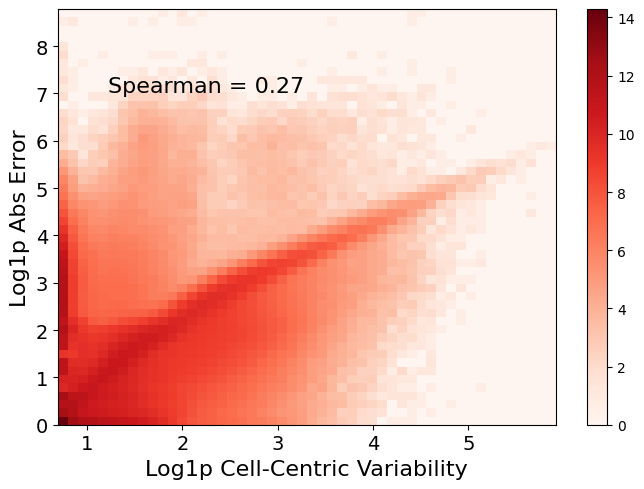

In [19]:
x = np.log1p(df["Uncertainty"])
y = np.log1p(df["Error"])

rho, p = spearmanr(x, y)
r, p = pearsonr(x, y)
print(rho)
print(r)

plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.xlabel("Log1p Cell-Centric Variability", fontsize=16)
plt.ylabel("Log1p Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'plots/scpi_datasets/uncertainty_error_correlations_log_COMBINED.pdf', bbox_inches='tight')
plt.show()